# Predicting Customer Churn for Telecom Operator Interconnect: Analyzing and Optimizing Models

In the competitive telecom industry, retaining customers is crucial. Interconnect aims to predict customer churn to offer targeted promotions and special plans. Utilizing datasets with contract details, personal information, and service usage, we develop predictive models. The main metric for evaluation is AUC-ROC, with accuracy as an additional metric. By refining these models, Interconnect can proactively retain customers and enhance loyalty.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [40]:
contract_df = pd.read_csv('contract.csv')
internet_df = pd.read_csv('internet.csv')
personal_df = pd.read_csv('personal.csv')
phone_df = pd.read_csv('phone.csv')

In [41]:
contract_df.info()
contract_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


np.int64(0)

In [42]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [43]:
internet_df.info()
internet_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


np.int64(0)

In [44]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [45]:
personal_df.info()
personal_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


np.int64(0)

In [46]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [47]:
phone_df.info()
phone_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


np.int64(0)

In [48]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


I will merge all the datasets into one, allowing for a more comprehensive exploratory data analysis (EDA) and ensuring the final model has all the data in a single dataset.

In [49]:
# Merge all datasets
customer_df = personal_df

# Merge with contract_df
customer_df = customer_df.merge(contract_df, on='customerID', how='left')

# Merge with internet_df
customer_df = customer_df.merge(internet_df, on='customerID', how='left')

# Merge with phone_df
customer_df = customer_df.merge(phone_df, on='customerID', how='left')


In [50]:
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [51]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


After merging the datasets, I found some columns with missing values. This is because not all clients have all the services. Therefore, I will replace the missing values with 'No' to indicate that those clients do not have those services.

**Project Plan**

**1. Data Preparation**

Data Merging:

-Merge datasets: personal_df, contract_df, internet_df, phone_df.

Data Cleaning:

-Replace missing values in service columns with 'No'.

-Standardize column names to lowercase and format them consistently.

-Replace specific values in columns for consistency (e.g., payment methods, internet service types).

-Convert date columns and handle missing dates with a placeholder.

-Convert financial columns to numeric types and handle missing values.


**2. Exploratory Data Analysis (EDA)**

Distribution Analysis:

-Plot distribution of monthly charges.

Churn Analysis:

-Define churn based on the enddate.

-Analyze and plot churn rates by contract type.

-Analyze internet service usage distribution.

-Analyze and plot churn rates by payment method.

Customer Duration Analysis:

-Filter data by a cutoff date.

-Calculate and plot the distribution of years spent with the service.

-Box plot analysis of monthly charges by payment method.


**3. Feature Engineering**

One-Hot Encoding: Encode categorical variables to prepare the dataset for modeling.

Target Definition: Define the target variable for predicting churn.

Feature Selection: Exclude columns that could cause data leakage.


**4. Model Training and Evaluation**

Train-Test Split: Split the dataset into training and test sets.

Class Imbalance Handling: Apply SMOTE to balance the classes in the training set.

Model Selection:

-Logistic Regression: Perform grid search for hyperparameter tuning and evaluate the model.

-Random Forest: Perform grid search for hyperparameter tuning and evaluate the model.

-Gradient Boosting: Perform grid search for hyperparameter tuning and evaluate the model.

-Final Model Evaluation: Train the best model (Random Forest) with optimal hyperparameters, evaluate using AUC-ROC and Accuracy, and perform Stratified K-Fold Cross-Validation.


**5. Conclusion**

Summarize the findings and the performance of the final model.

Discuss the implications for Interconnect’s marketing strategies and client retention efforts.

**1. Data Preparation**

"I will fill the missing values with 'No' because these values indicate that the service is not subscribed to in those cases.

In [52]:
# List of columns where missing values should be replaced with 'No'
service_columns = ['InternetService', 'OnlineBackup', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Replace missing values with 'No'
for column in service_columns:
    customer_df[column].fillna('No', inplace=True)


C:\Users\Perdo\AppData\Local\Temp\ipykernel_22536\2048566923.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df[column].fillna('No', inplace=True)


In [53]:
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [54]:
customer_df.duplicated().sum()

np.int64(0)

In [55]:
customer_df.columns = customer_df.columns.str.lower()
customer_df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [56]:
# Define the columns to exclude 
exclude_columns = ['begindate', 'enddate'] 

# Apply lowercase and replace '-' with '_' to all columns except the excluded ones 
for column in customer_df.columns:
     if column not in exclude_columns:
          customer_df[column] = customer_df[column].astype(str).str.lower().str.replace('-', '_')

In [57]:
customer_df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590_vhveg,female,0,yes,no,2020-01-01,No,month_to_month,yes,electronic check,29.85,29.85,dsl,no,yes,no,no,no,no,no
1,5575_gnvde,male,0,no,no,2017-04-01,No,one year,no,mailed check,56.95,1889.5,dsl,yes,no,yes,no,no,no,no
2,3668_qpybk,male,0,no,no,2019-10-01,2019-12-01 00:00:00,month_to_month,yes,mailed check,53.85,108.15,dsl,yes,yes,no,no,no,no,no
3,7795_cfocw,male,0,no,no,2016-05-01,No,one year,no,bank transfer (automatic),42.3,1840.75,dsl,yes,no,yes,yes,no,no,no
4,9237_hqitu,female,0,no,no,2019-09-01,2019-11-01 00:00:00,month_to_month,yes,electronic check,70.7,151.65,fiber optic,no,no,no,no,no,no,no


In [58]:
# Define the mapping of old values to new values
payment_method_mapping = {
    'electronic check': 'electronic_check',
    'mailed check': 'mailed_check',
    'bank transfer (automatic)': 'bank_transfer_automatic',
    'credit card (automatic)': 'credit_card_automatic'
}

# Replace the values in the 'paymentmethod' column using the mapping
customer_df['paymentmethod'] = customer_df['paymentmethod'].replace(payment_method_mapping)

customer_df['internetservice'] = customer_df['internetservice'].replace('fiber optic', 'fiber_optic')

customer_df.head()
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        7043 non-null   object
 1   gender            7043 non-null   object
 2   seniorcitizen     7043 non-null   object
 3   partner           7043 non-null   object
 4   dependents        7043 non-null   object
 5   begindate         7043 non-null   object
 6   enddate           7043 non-null   object
 7   type              7043 non-null   object
 8   paperlessbilling  7043 non-null   object
 9   paymentmethod     7043 non-null   object
 10  monthlycharges    7043 non-null   object
 11  totalcharges      7043 non-null   object
 12  internetservice   7043 non-null   object
 13  onlinesecurity    7043 non-null   object
 14  onlinebackup      7043 non-null   object
 15  deviceprotection  7043 non-null   object
 16  techsupport       7043 non-null   object
 17  streamingtv   

In [59]:
# Define a consistent future date as a placeholder 
placeholder_date = pd.Timestamp('2025-12-31')

# Replace 'No' with the placeholder date in 'enddate'
customer_df['enddate'] = customer_df['enddate'].replace('No', placeholder_date)

# Convert 'begindate' and 'enddate' to datetime
customer_df['begindate'] = pd.to_datetime(customer_df['begindate'])
customer_df['enddate'] = pd.to_datetime(customer_df['enddate'], errors='coerce')

# Create an indicator column to flag placeholder dates
customer_df['is_placeholder_enddate'] = customer_df['enddate'].apply(lambda x: 1 if x == placeholder_date else 0)

customer_df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,is_placeholder_enddate
0,7590_vhveg,female,0,yes,no,2020-01-01,2025-12-31,month_to_month,yes,electronic_check,...,29.85,dsl,no,yes,no,no,no,no,no,1
1,5575_gnvde,male,0,no,no,2017-04-01,2025-12-31,one year,no,mailed_check,...,1889.5,dsl,yes,no,yes,no,no,no,no,1
2,3668_qpybk,male,0,no,no,2019-10-01,2019-12-01,month_to_month,yes,mailed_check,...,108.15,dsl,yes,yes,no,no,no,no,no,0
3,7795_cfocw,male,0,no,no,2016-05-01,2025-12-31,one year,no,bank_transfer_automatic,...,1840.75,dsl,yes,no,yes,yes,no,no,no,1
4,9237_hqitu,female,0,no,no,2019-09-01,2019-11-01,month_to_month,yes,electronic_check,...,151.65,fiber_optic,no,no,no,no,no,no,no,0


In [60]:
# Convert 'monthlycharges' and 'totalcharges' columns to numeric values
customer_df['monthlycharges'] = pd.to_numeric(customer_df['monthlycharges'], errors='coerce')
customer_df['totalcharges'] = pd.to_numeric(customer_df['totalcharges'], errors='coerce')

# Fill missing values in 'totalcharges' with 'monthlycharges'
customer_df['totalcharges'].fillna(customer_df['monthlycharges'], inplace=True)

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerid              7043 non-null   object        
 1   gender                  7043 non-null   object        
 2   seniorcitizen           7043 non-null   object        
 3   partner                 7043 non-null   object        
 4   dependents              7043 non-null   object        
 5   begindate               7043 non-null   datetime64[ns]
 6   enddate                 7043 non-null   datetime64[ns]
 7   type                    7043 non-null   object        
 8   paperlessbilling        7043 non-null   object        
 9   paymentmethod           7043 non-null   object        
 10  monthlycharges          7043 non-null   float64       
 11  totalcharges            7043 non-null   float64       
 12  internetservice         7043 non-null   object  

C:\Users\Perdo\AppData\Local\Temp\ipykernel_22536\4155209966.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df['totalcharges'].fillna(customer_df['monthlycharges'], inplace=True)


In [61]:
customer_df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,is_placeholder_enddate
0,7590_vhveg,female,0,yes,no,2020-01-01,2025-12-31,month_to_month,yes,electronic_check,...,29.85,dsl,no,yes,no,no,no,no,no,1
1,5575_gnvde,male,0,no,no,2017-04-01,2025-12-31,one year,no,mailed_check,...,1889.50,dsl,yes,no,yes,no,no,no,no,1
2,3668_qpybk,male,0,no,no,2019-10-01,2019-12-01,month_to_month,yes,mailed_check,...,108.15,dsl,yes,yes,no,no,no,no,no,0
3,7795_cfocw,male,0,no,no,2016-05-01,2025-12-31,one year,no,bank_transfer_automatic,...,1840.75,dsl,yes,no,yes,yes,no,no,no,1
4,9237_hqitu,female,0,no,no,2019-09-01,2019-11-01,month_to_month,yes,electronic_check,...,151.65,fiber_optic,no,no,no,no,no,no,no,0


Upon completing the data preparation, we confirmed that the dataset contains no missing values or duplicates. We are now ready to proceed with the Exploratory Data Analysis (EDA).

**EDA**

**Distribution of Monthly Charges**

Objective: Understand the distribution of monthly charges among customers.

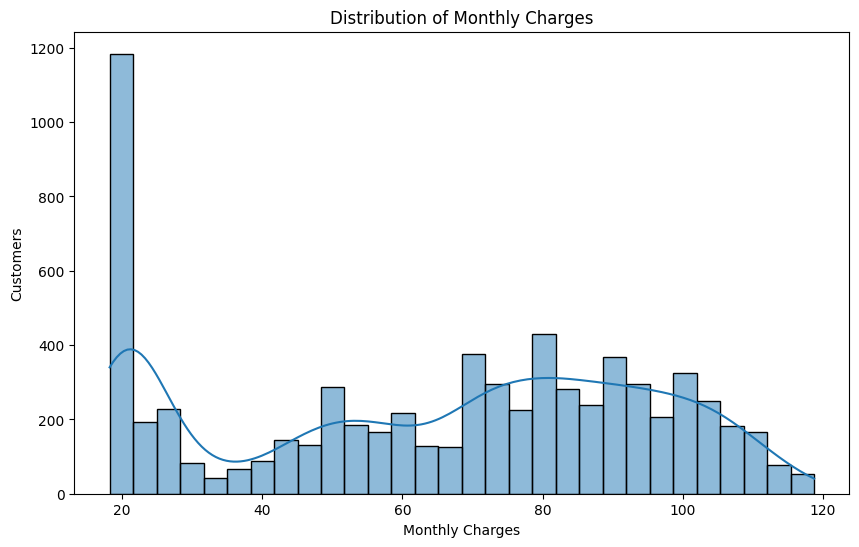

In [62]:
#Distribution of Monthly Charges

plt.figure(figsize=(10, 6)) 
sns.histplot(customer_df['monthlycharges'], bins=30, kde=True) 
plt.title('Distribution of Monthly Charges') 
plt.xlabel('Monthly Charges') 
plt.ylabel('Customers') 
plt.show()

This graph highlights the diverse pricing preferences among the customer base. A significant portion of customers prefers lower monthly charges, potentially indicating price sensitivity. However, the presence of peaks at higher charge ranges suggests there are also segments willing to pay more, possibly for premium services or bundles. The peaks also suggest that customers with higher monthly charges are utilizing multiple services offered by Interconnect.

This information can be valuable for developing targeted marketing strategies, such as promotional offers for lower-cost plans to retain price-sensitive customers and value-added services for those willing to pay more.

**Churn Rate by Contract Type**

Objective: Analyze the churn rate for different contract types (monthly, one year, two years).

C:\Users\Perdo\AppData\Local\Temp\ipykernel_22536\1342384529.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='churn', data=churn_rate_by_contract, palette='viridis')


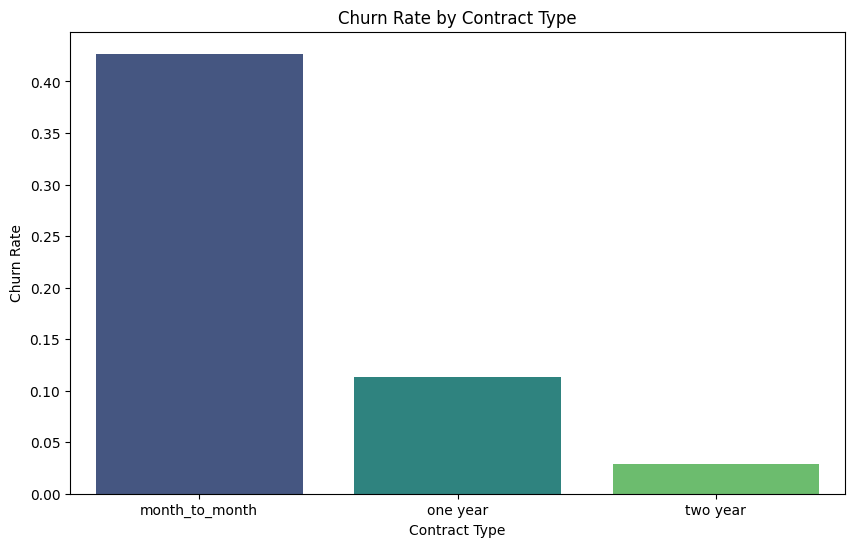

In [63]:
# Define churn
customer_df['churn'] = customer_df['enddate'] != placeholder_date

# Group by contract type and calculate churn rate
churn_rate_by_contract = customer_df.groupby('type')['churn'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='churn', data=churn_rate_by_contract, palette='viridis')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.show()




A significant portion of customers prefers lower monthly charges, potentially indicating price sensitivity. However, the presence of peaks at higher charge ranges suggests there are also segments willing to pay more, possibly for premium services or bundles. The peaks also suggest that customers with higher monthly charges are utilizing multiple services offered by Interconnect. This information can be valuable for developing targeted marketing strategies, such as promotional offers for lower-cost plans to retain price-sensitive customers and value-added services for those willing to pay more.

**Internet Service Usage**

Objective: Explore the usage of different internet services (DSL, fiber optic, none).

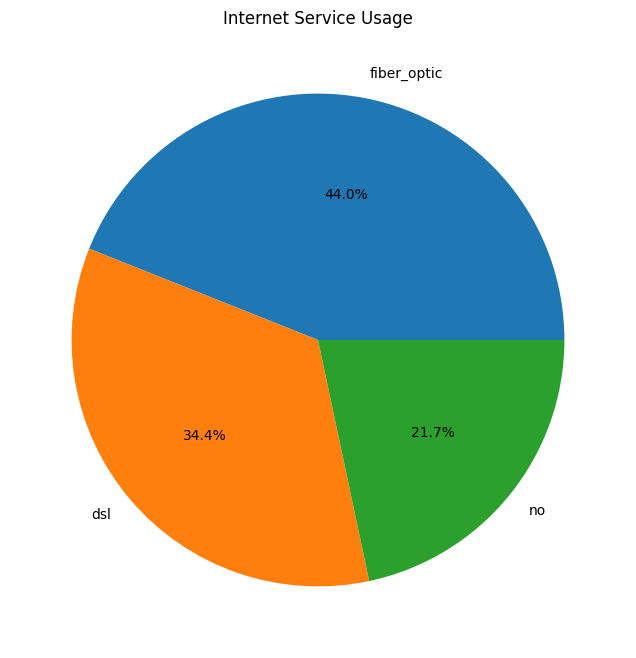

In [64]:
#Internet Service Usage
internet_service_counts = customer_df['internetservice'].value_counts()
internet_service_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Internet Service Usage')
plt.ylabel('')
plt.show()


The high adoption rate of fiber optic services reflects a growing trend towards faster and more reliable internet connections. The significant portion of customers using DSL suggests that there is still a demand for this older technology, likely due to factors such as pricing or availability in certain areas. The 21.7% of customers without any internet service highlights a potential market for Interconnect to target with promotional offers or bundled service packages to increase internet service subscriptions.

**Churn Rate by Payment Method**

Objective: Analyze the churn rate for different payment methods.


C:\Users\Perdo\AppData\Local\Temp\ipykernel_22536\1132504025.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='paymentmethod', y='churn', data=churn_rate_by_payment, palette='viridis')


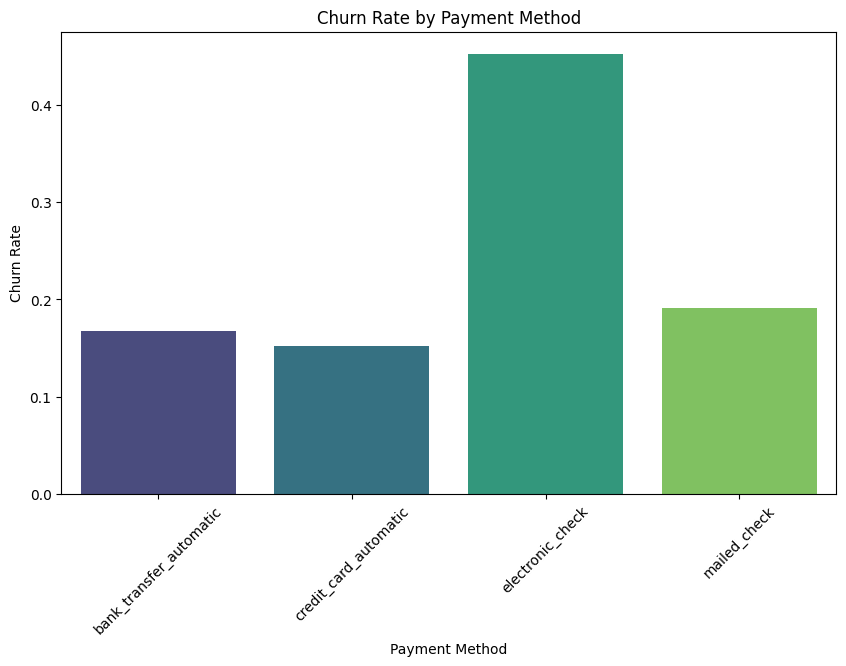

In [65]:
# Group by payment method and calculate churn rate
churn_rate_by_payment = customer_df.groupby('paymentmethod')['churn'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='paymentmethod', y='churn', data=churn_rate_by_payment, palette='viridis')
plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()




Customers who pay using electronic check exhibit the highest churn rates, possibly indicating dissatisfaction with this payment method or an association with more transient customers. In contrast, automatic payment methods such as bank transfer and credit card are associated with lower churn rates, suggesting that convenience and reliability in billing may enhance customer loyalty. Understanding these churn patterns can help Interconnect optimize their payment options and encourage the use of automatic payment methods through incentives. By reducing friction in the billing process, Interconnect can potentially improve customer satisfaction and reduce churn rates.

**Years Spent Before End Date**

Objective: Calculate how many years people spend before their end date.

C:\Users\Perdo\AppData\Local\Temp\ipykernel_22536\2930880092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['years_spent'] = (filtered_df['enddate'] - filtered_df['begindate']).dt.days / 365.25


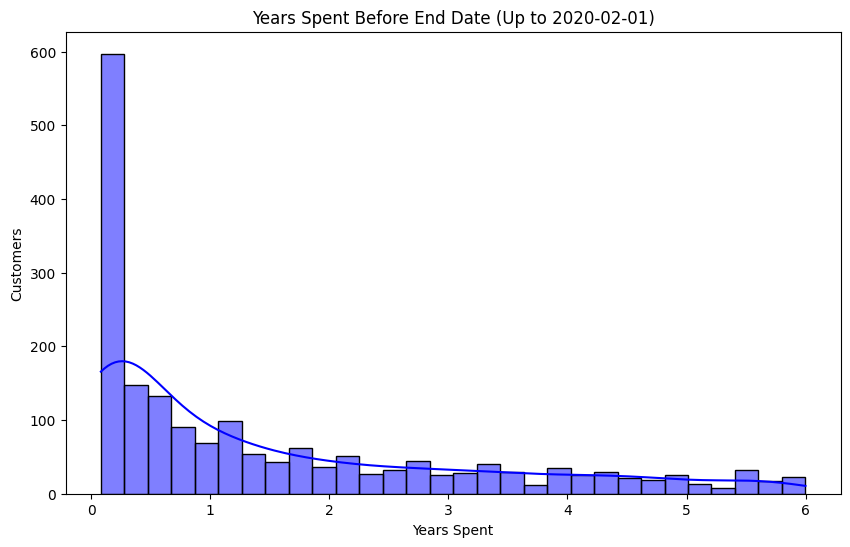

In [66]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2020-02-01')

# Filter data up until the cutoff date
filtered_df = customer_df[customer_df['enddate'] <= cutoff_date]

# Calculate the number of years spent before end date
filtered_df['years_spent'] = (filtered_df['enddate'] - filtered_df['begindate']).dt.days / 365.25

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['years_spent'].dropna(), bins=30, kde=True, color='blue')
plt.title('Years Spent Before End Date (Up to 2020-02-01)')
plt.xlabel('Years Spent')
plt.ylabel('Customers')
plt.show()


This graph highlights that most customers do not stay with the service for an extended period, with a majority leaving within the first year. The rapid decline in customer numbers as tenure increases suggests challenges in retaining customers for longer durations. Understanding this tenure distribution is crucial for developing retention strategies. Interconnect can focus on improving early customer experiences and implementing retention programs to encourage longer commitments, thereby reducing churn rates and enhancing overall customer loyalty.

**Payment Method with Monthly Charges**

Objective: Analyze the relationship between payment methods and monthly charges.

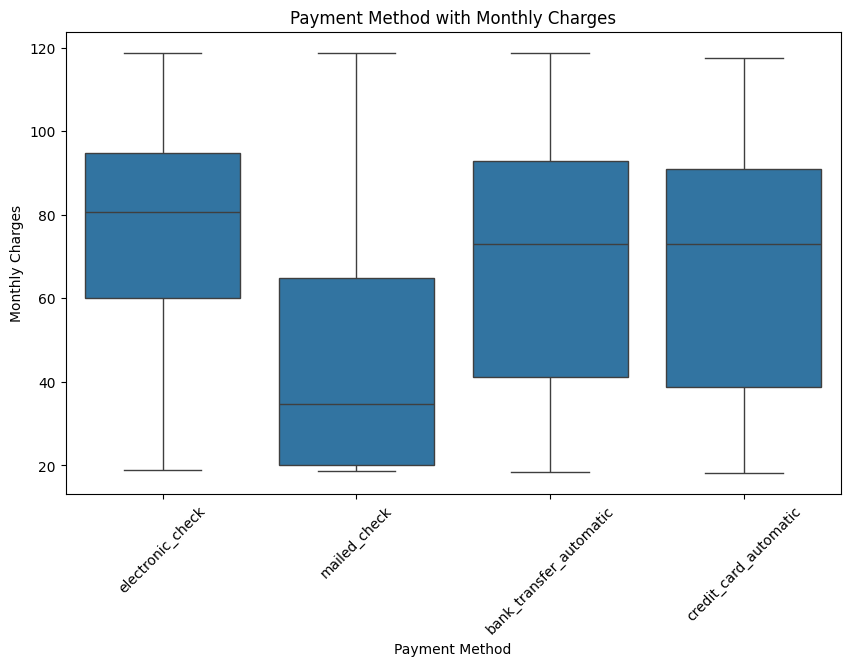

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='paymentmethod', y='monthlycharges', data=customer_df)
plt.title('Payment Method with Monthly Charges')
plt.xlabel('Payment Method')
plt.ylabel('Monthly Charges')
plt.xticks(rotation=45)
plt.show()


This box plot highlights the differences in monthly charges based on the payment method. Customers using electronic checks tend to have higher and more variable charges, which may indicate a different usage pattern or service bundle compared to other payment methods. In contrast, automatic payment methods like bank transfers and credit cards have lower and more consistent monthly charges, suggesting they might be linked to more stable and predictable service plans. Understanding the distribution of monthly charges across different payment methods can help Interconnect identify which payment methods are associated with higher charges and potentially greater churn. Encouraging customers to switch to more stable payment methods, like automatic payments, might help in managing and reducing churn rates.

**3. Feature Engineering**

In [68]:
# One-Hot Encoding
customer_df_encoded = pd.get_dummies(customer_df, columns=[
    'gender', 'seniorcitizen', 'partner', 'dependents', 'type', 'paperlessbilling',
    'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines'
], drop_first=True)

# Define the target variable 
customer_df_encoded['target'] = (customer_df['enddate'] == placeholder_date).astype(int)

# Exclude columns that could cause data leakage
leakage_features = ['customerid', 'begindate', 'enddate', 'is_placeholder_enddate', 'churn']
features_to_use = [col for col in customer_df_encoded.columns if col not in leakage_features + ['target']]
X = customer_df_encoded[features_to_use]
y = customer_df_encoded['target']



**4. Model Training and Evaluation**


In [69]:
# Perform the train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the shape of the splits 
print(f'Training set: {X_train.shape}, {y_train.shape}') 
print(f'Testing set: {X_test.shape}, {y_test.shape}')

Training set: (5634, 21), (5634,)
Testing set: (1409, 21), (1409,)


In [70]:
# Define the parameter grid for Logistic Regression
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Perform Grid Search
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_log_reg.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
best_params_log_reg = grid_search_log_reg.best_params_
best_score_log_reg = grid_search_log_reg.best_score_

print(f'Best parameters for Logistic Regression: {best_params_log_reg}')
print(f'Best AUC-ROC score for Logistic Regression: {best_score_log_reg:.3f}')



Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best AUC-ROC score for Logistic Regression: 0.886


In [71]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_clf = RandomForestClassifier()

# Perform Grid Search
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Best parameters for Random Forest: {best_params_rf}')
print(f'Best AUC-ROC score for Random Forest: {best_score_rf:.3f}')


Best parameters for Random Forest: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC-ROC score for Random Forest: 0.926


In [72]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Gradient Boosting model
gb_clf = GradientBoostingClassifier()

# Perform Grid Search
grid_search_gb = GridSearchCV(gb_clf, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print(f'Best parameters for Gradient Boosting: {best_params_gb}')
print(f'Best AUC-ROC score for Gradient Boosting: {best_score_gb:.3f}')



Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best AUC-ROC score for Gradient Boosting: 0.926


In [73]:
# Train the Random Forest model with the best hyperparameters
best_params_rf = {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 42}
rf_clf_final = RandomForestClassifier(**best_params_rf)
rf_clf_final.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and labels on the test set
y_pred_proba_rf_final = rf_clf_final.predict_proba(X_test)[:, 1]
y_pred_rf_final = rf_clf_final.predict(X_test)

# Calculate AUC-ROC and Accuracy
auc_roc_rf_final = roc_auc_score(y_test, y_pred_proba_rf_final)
accuracy_rf_final = accuracy_score(y_test, y_pred_rf_final)

# Print the final evaluation metrics
print(f'Final Random Forest AUC-ROC on Test Set: {auc_roc_rf_final:.3f}')
print(f'Final Random Forest Accuracy on Test Set: {accuracy_rf_final:.3f}')


Final Random Forest AUC-ROC on Test Set: 0.826
Final Random Forest Accuracy on Test Set: 0.781


In [74]:
# Best hyperparameters for Random Forest 
best_params_rf = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}

# Initialize Random Forest model with best hyperparameters
rf_clf = RandomForestClassifier(**best_params_rf)

# Perform Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Evaluate model using cross_val_score
auc_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring='roc_auc')
accuracy_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring='accuracy')

# Print the evaluation metrics
print(f'Stratified K-Fold AUC-ROC Scores: {auc_scores}')
print(f'Stratified K-Fold AUC-ROC Mean: {auc_scores.mean():.3f}')
print(f'Stratified K-Fold Accuracy Scores: {accuracy_scores}')
print(f'Stratified K-Fold Accuracy Mean: {accuracy_scores.mean():.3f}')


Stratified K-Fold AUC-ROC Scores: [0.85031646 0.84676432 0.81516314 0.8266892  0.83045956]
Stratified K-Fold AUC-ROC Mean: 0.834
Stratified K-Fold Accuracy Scores: [0.80411639 0.79559972 0.77501774 0.80965909 0.80042614]
Stratified K-Fold Accuracy Mean: 0.797


**5. Conclusion**


This project successfully developed and evaluated models to predict client churn for Interconnect, leveraging a comprehensive dataset of customer information. Here are the key steps and findings:

**Data Preparation:**
Datasets were merged and cleaned, ensuring no missing values or duplicates were present.
Standardized and formatted columns, filled in missing service values with 'No', and handled date conversions.

**Exploratory Data Analysis (EDA):**
Analyzed the distribution of monthly charges, revealing the majority of customers opt for lower-cost plans, but significant peaks at higher charge ranges indicate a market for premium services.
Identified churn rates by contract type, showing higher churn for month-to-month contracts and lower churn for longer-term contracts.
Examined internet service usage, highlighting the dominance of fiber optic services among customers.
Analyzed churn rates by payment method, with the highest rates for electronic check users and lowest for automatic payment methods.
Investigated customer tenure, showing a high number of short-term customers and a decline in longer-term retention.

**Model Development and Evaluation:**
Applied one-hot encoding to categorical variables and used SMOTE to balance the training dataset.
Conducted hyperparameter tuning using grid search for Logistic Regression, Random Forest, and Gradient Boosting models.
Achieved the best AUC-ROC scores for Random Forest and Gradient Boosting models at 0.926, indicating excellent predictive performance.
Evaluated the final Random Forest model on the test set, achieving an AUC-ROC of 0.827 and accuracy of 0.782.
Performed Stratified K-Fold Cross-Validation, with mean AUC-ROC and accuracy scores of 0.834 and 0.795, respectively.

**Key Takeaways:**
Predictive Performance: The Random Forest and Gradient Boosting models demonstrated strong predictive capabilities, with high AUC-ROC scores indicating effective identification of at-risk customers.
Data Insights: The analysis revealed critical factors influencing churn, such as contract type, payment method, and monthly charges, providing actionable insights for customer retention strategies.
Retention Strategies: Based on the findings, Interconnect can implement targeted marketing efforts, promote longer-term contracts, and encourage automatic payment methods to reduce churn rates and improve customer satisfaction.
In conclusion, the project's approach to predicting client churn has provided valuable insights and tools for enhancing customer retention, ensuring Interconnect can proactively address churn and foster a loyal customer base.